$$
\dfrac{\textrm{d}S(t)}{\textrm{d}t} = \lambda S(t) \left[1 - \dfrac{S(t)}{K} \right]
$$

In [153]:
using Plots, DifferentialEquations
using LinearAlgebra
using NLopt
using .Threads 
using Interpolations
using Distributions
using Roots
gr()
a=zeros(4)
λg =0.005; Kg=80.0; C0g=2.0; σg  =2.0;
t=[0, 769,1140,1488,1876,2233,2602,2889,3213,3621,4028];
data = [2.352254642,4.396074415,8.434146341,22.25079365,38.9,59.04803013,67.84648814,69.51641791,74.09765494,82.29230769,80.88291457];

In [154]:
function DE!(dC,C,p,t)
λ,K=p
dC[1]=λ*C[1]*(1.0-C[1]/K);
end

DE! (generic function with 1 method)

In [155]:
function odesolver(t,λ,K,C0)
p=(λ,K)
tspan=(0.0,maximum(t))
prob=ODEProblem(DE!,[C0],tspan,p)
sol=solve(prob,saveat=t)
return sol[1,:]
end

odesolver (generic function with 1 method)

In [156]:
function model(t,a)
y=zeros(length(t))
y=odesolver(t,a[1],a[2],a[3])
    return y
end

model (generic function with 1 method)

In [157]:
function error(data,a)
    y=zeros(length(t))
    y=model(t,a);
    e=0;
    dist=Normal(0,a[4]);
    e=loglikelihood(dist,data-y) 
    return sum(e)
end

error (generic function with 1 method)

In [158]:
function fun(a)
return error(data,a)
end

fun (generic function with 1 method)

In [159]:
function optimise(fun,θ₀,lb,ub;
    dv = false,
    method = dv ? :LD_LBFGS : :LN_BOBYQA,
)

if dv || String(method)[2] == 'D'
    tomax = fun
else
    tomax = (θ,∂θ) -> fun(θ)
end

opt = Opt(method,length(θ₀))
opt.max_objective = tomax
opt.lower_bounds = lb       # Lower bound
opt.upper_bounds = ub       # Upper bound
#opt.local_optimizer = Opt(:LN_BOBYQA, length(θ₀))
opt.local_optimizer = Opt(:LN_NELDERMEAD, length(θ₀))
res = optimize(opt,θ₀)
return res[[2,1]]
end

optimise (generic function with 1 method)

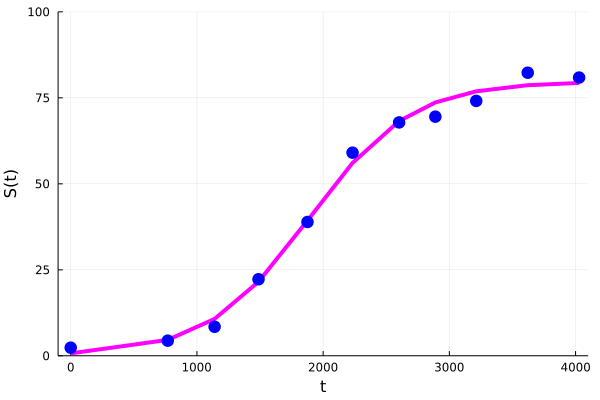

-24.780781297643838

In [160]:
Cmle=zeros(length(t))
θG = [λg,Kg,C0g,σg]
lb=[0,0,0,0]
ub=[1,100,10,10]
(xopt,fopt)  = optimise(fun,θG,lb,ub)
fmle=fopt
λmle=xopt[1]; 
Kmle=xopt[2]; 
C0mle=xopt[3]; 
σmle=xopt[4];
for j in 1:length(t)
Cmle[j] = Kmle*C0mle/((Kmle-C0mle)*exp(-λmle*t[j])+C0mle);
end       
p1=plot(t,Cmle,color=:fuchsia,xlabel="t",ylabel="S(t)",legend=false,lw=4,xlims=(-100,4100),ylims=(0,100),xticks=[0,1000,2000,3000,4000],yticks=[0,25,50,75,100])
p1=scatter!(t,data,legend=false,msw=0,ms=7,color=:blue,msa=:blue)
display(p1)
savefig(p1, "mle.pdf")
fopt

In [161]:
#Profile λ
nptss=40
λmin=λmle/2
λmax=λmle*2
λrange=LinRange(λmin,λmax,nptss)
nrange=zeros(3,nptss)
llλ=zeros(nptss)
nllλ=zeros(nptss)
predictλ=zeros(length(t),nptss)

for i in 1:nptss
function fun1(aa)
return error(data,[λrange[i],aa[1],aa[2],aa[3]])
end

local lb1=[0.0,0.0,0.0]
local ub1=[100,10,10]
local θG1 = [Kmle,C0mle,σmle]
    
local (xo,fo)=optimise(fun1,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llλ[i]=fo[1]
predictλ[:,i]=model(t,[λrange[i],nrange[1,i],nrange[2,i],nrange[3,i]])
end

nllλ=llλ.-maximum(llλ);


λp=zeros(length(t))
λm=1000*ones(length(t))

for i in 1:nptss
if nllλ[i] >= -1.921
    for j in 1:length(t)
    λp[j]=max(predictλ[j,i],λp[j])
    λm[j]=min(predictλ[j,i],λm[j])
    end
end

end


In [162]:
#Profile K
Kmin=70
Kmax=90
Krange=LinRange(Kmin,Kmax,nptss)
nrange=zeros(3,nptss)
llK=zeros(nptss)
nllK=zeros(nptss)
predictK=zeros(length(t),nptss)


for i in 1:nptss
function fun2(aa)
return error(data,[aa[1],Krange[i],aa[2],aa[3]])
end

local lb1=[0.0,0.0,0.0]
local ub1=[100,100,100]
local θG1 = [λmle,C0mle,σmle]
    
local (xo,fo)=optimise(fun2,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llK[i]=fo[1]
predictK[:,i]=model(t,[nrange[1,i],Krange[i],nrange[2,i],nrange[3,i]])    
end

nllK=llK.-maximum(llK);

Kp=zeros(length(t))
Km=1000*ones(length(t))

for i in 1:nptss
if nllK[i] >= -1.921
    for j in 1:length(t)
    Kp[j]=max(predictK[j,i],Kp[j])
    Km[j]=min(predictK[j,i],Km[j])
    end
end

end


In [163]:
#Profile C0
C0min=C0mle/20
C0max=C0mle*5
C0range=LinRange(C0min,C0max,nptss)
nrange=zeros(3,nptss)
llC0=zeros(nptss)
nllC0=zeros(nptss)
predictC0=zeros(length(t),nptss)

for i in 1:nptss
function fun3(aa)
return error(data,[aa[1],aa[2],C0range[i],aa[3]])
end

local lb1=[0.0,0.0,0.0]
local ub1=[100,100,100]
local θG1=[λmle,Kmle,σmle]

local (xo,fo)=optimise(fun3,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llC0[i]=fo[1]
predictC0[:,i]=model(t,[nrange[1,i],nrange[2,i],C0range[i],nrange[3,i]])  
end

nllC0=llC0.-maximum(llC0);


C0p=zeros(length(t))
C0m=1000*ones(length(t))

for i in 1:nptss
if nllC0[i] >= -1.921
    for j in 1:length(t)
    C0p[j]=max(predictC0[j,i],C0p[j])
    C0m[j]=min(predictC0[j,i],C0m[j])
    end
end

end


In [164]:
#Profile sigma
σmin=σmle/2
σmax=σmle*2
σrange=LinRange(σmin,σmax,nptss)
nrange=zeros(3,nptss)
llσ=zeros(nptss)
nllσ=zeros(nptss)

for i in 1:nptss
function fun5(aa)
return error(data,[aa[1],aa[2],aa[3],σrange[i]])
end

local lb1=[0.0,0.0,0.0]
local ub1=[1,100,10]
local θG1=[λmle,Kmle,C0mle]
  
local (xo,fo)=optimise(fun5,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llσ[i]=fo[1]
end

nllσ=llσ.-maximum(llσ);


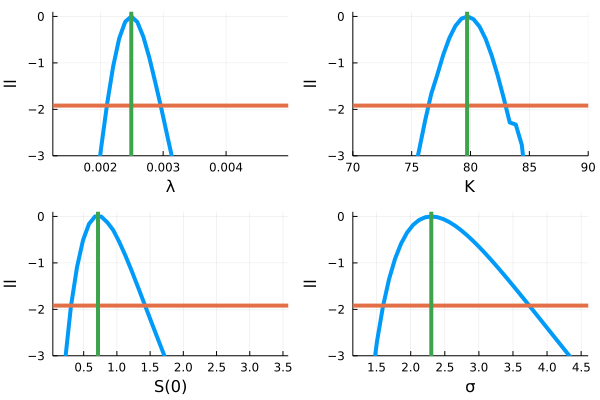

In [165]:
s1=plot(λrange,nllλ,xlim=(λmin,λmax),lw=4,ylim=(-3,0.1),xlabel="λ",ylabel="ll",legend=false,xticks=[0.002,0.003,0.004])
s1=hline!([-1.92],lw=4)
s1=vline!([λmle],lw=4)
s2=plot(Krange,nllK,xlim=(Kmin,Kmax),lw=4,ylim=(-3,0.1),xlabel="K",ylabel="ll",legend=false)
s2=hline!([-1.92],lw=4)
s2=vline!([Kmle],lw=4)
s3=plot(C0range,nllC0,xlim=(C0min,C0max),lw=4,ylim=(-3,0.1),xlabel="S(0)",ylabel="ll",legend=false)
s3=hline!([-1.92],lw=4)
s3=vline!([C0mle],lw=4)
s4=plot(σrange,nllσ,xlim=(σmin,σmax),lw=4,ylim=(-3,0.1),xlabel="σ",ylabel="ll",legend=false)
s4=hline!([-1.92],lw=4)
s4=vline!([σmle],lw=4)


s5=plot(s1,s2,s3,s4,layout=(2,2),legend=false)
display(s5)
savefig(s5, "profiles.pdf")

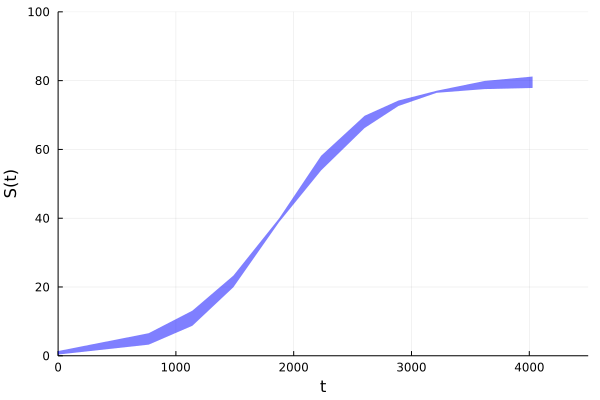

In [166]:
q2=plot(t,Cmle,w=0,c=:blue,ribbon=(Cmle.-λm,λp.-Cmle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="S(t)")

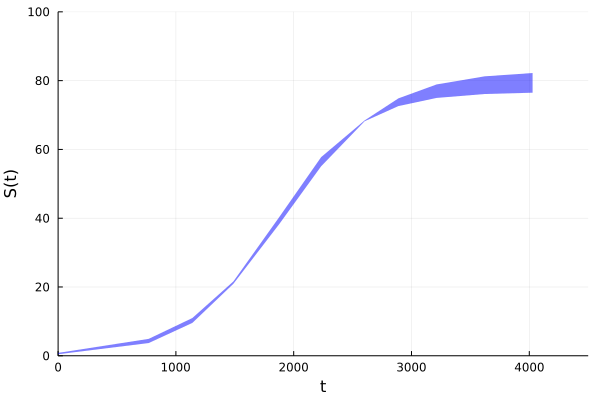

In [167]:
q3=plot(t,Cmle,w=0,c=:blue,ribbon=(Cmle.-Km,Kp.-Cmle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="S(t)")

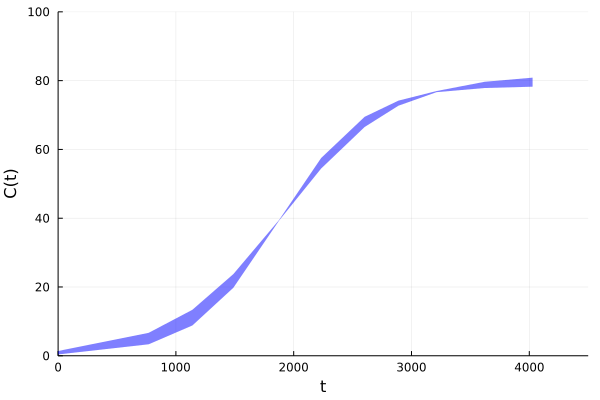

In [168]:
q4=plot(t,Cmle,w=0,c=:blue,ribbon=(Cmle.-C0m,C0p.-Cmle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C(t)")

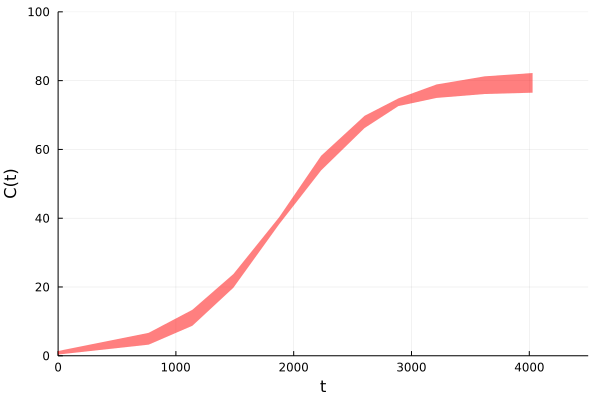

In [169]:
Up=zeros(length(t))
Um=zeros(length(t))
for i in 1:length(t)
Up[i] = max(λp[i],Kp[i],C0p[i])
Um[i] = min(λm[i],Km[i],C0m[i])
end
q5=plot(t,Cmle,w=0,c=:red,ribbon=(Cmle.-Um,Up.-Cmle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C(t)")

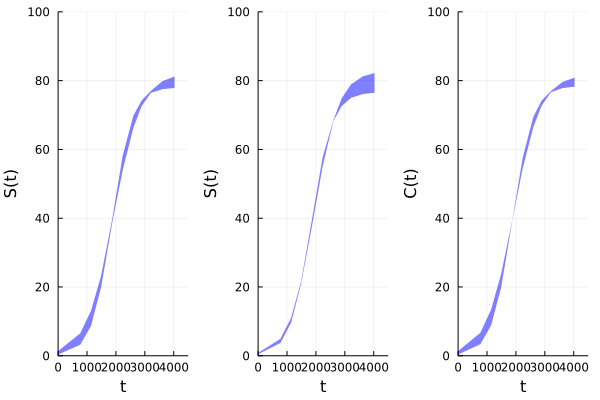

In [170]:
q6=plot(q2,q3,q4,layout=(1,3),legend=false)
display(q6)
savefig(q6, "Intervals.pdf")


In [171]:
xopt

4-element Vector{Float64}:
  0.0024935183224559245
 79.70888247271019
  0.7156875659198295
  2.301729410979296

In [172]:
savefig(q5, "Union1.pdf")

In [173]:
quantile(Chisq(1),0.95)/2

1.9207294103470622

In [174]:
quantile(Chisq(3),0.95)/2

3.9073639516255887

In [175]:
ss=plot(t,Cmle,label=false)
λλ=LinRange(0.001,0.004,30)
KK=LinRange(75,85,30)
CC0=LinRange(0.0,1.0,30)
ll=zeros(length(λλ),length(KK),length(CC0))
predictll=zeros(length(t),length(λλ)*length(KK)*length(CC0))

for i in 1:length(λλ)
    for j in 1:length(KK)
        for k in 1:length(CC0)
ll[i,j,k]=error(data,[λλ[i],KK[j],CC0[k],Vmle]) #This is the loglikelihood
        end
end
end

num=0
for i in 1:length(λλ)
    for j in 1:length(KK)
        for k in 1:length(CC0)     
       if ll[i,j,k]-maximum(ll) > -3.91
       num=num+1
                predictll[:,i*j*k]=model(t,[λλ[i],KK[j],CC0[k],Vmle]) 
       ss=plot!(t,predictll[:,i*j*k],label=false,color=:blue,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C(t)")         
       end
            
        
        end
end
end

#display(ss)


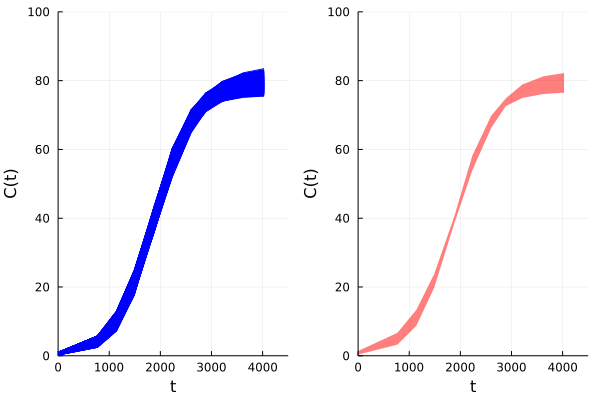

In [176]:
sss=plot(ss,q5,layout=(1,2),legend=false)
display(sss)
savefig(sss, "PredictionComparison.pdf")

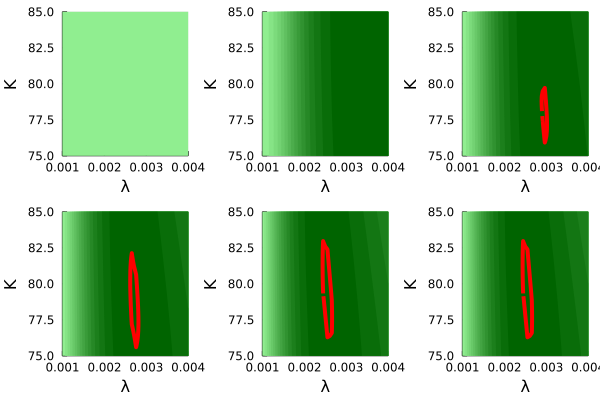

In [177]:
q1=contourf(λλ,KK,ll[:,:,1]'.-maximum(ll),linewidth=0,xlabel="λ",ylabel="K",c=:greens,colorbar=false)
q1=contour!(λλ,KK,ll[:,:,1]'.-maximum(ll),levels=[-3.91], lw=4, c=:red)
#q1=scatter!([λmle],[Kmle],markersize=3,markershape=:square,markercolor=:fuchsia,msw=0, ms=5,label=false)

q2=contourf(λλ,KK,ll[:,:,5]'.-maximum(ll),linewidth=0,xlabel="λ",ylabel="K",c=:greens,colorbar=false)
q2=contour!(λλ,KK,ll[:,:,5]'.-maximum(ll),levels=[-3.91], lw=4, c=:red)

q3=contourf(λλ,KK,ll[:,:,10]'.-maximum(ll),linewidth=0,xlabel="λ",ylabel="K",c=:greens,colorbar=false)
q3=contour!(λλ,KK,ll[:,:,10]'.-maximum(ll),levels=[-3.91], lw=4, c=:red)

q4=contourf(λλ,KK,ll[:,:,15]'.-maximum(ll),linewidth=0,xlabel="λ",ylabel="K",c=:greens,colorbar=false)
q4=contour!(λλ,KK,ll[:,:,15]'.-maximum(ll),levels=[-3.91], lw=4, c=:red)

q5=contourf(λλ,KK,ll[:,:,20]'.-maximum(ll),linewidth=0,xlabel="λ",ylabel="K",c=:greens,colorbar=false)
q5=contour!(λλ,KK,ll[:,:,20]'.-maximum(ll),levels=[-3.91], lw=4, c=:red)

q6=contourf(λλ,KK,ll[:,:,20]'.-maximum(ll),linewidth=0,xlabel="λ",ylabel="K",c=:greens,colorbar=false)
q6=contour!(λλ,KK,ll[:,:,20]'.-maximum(ll),levels=[-3.91], lw=4, c=:red)


q7=plot(q1,q2,q3,q4,q5,q6,layout=(2,3),legend=false)
display(q7)